# Проект "Анализ пользовательского поведения в мобильном приложении"

## Описание проекта
Стартапу, занимающемуся продажей продуктов питания, необходимо знать, как пользователи их мобильного приложения ведут себя. В этом отношении их особенно интересует поведение пользователей в контексте воронки продаж:  
- как много конвертируются в покупку,
- каким образом происходит конверсия в воронке,
- сколько пользователей не доходят до покупки, останавливаясь на промежуточных этапах воронки,
- на каких именно этапах пользователи останавливаются в движении по воронке.  

Также дизайнеры стартапа хотят изменить шрифт в приложении, что вызывает опасения у менеджмента, поэтому требуется провести А/А/В-тест как некоторый компромис в принятии решений. Именно по  результатам теста будет принято решение об измнении/сохранении шрифта приложения.

## Цели и задачи проекта
Целью проекта выступает анализ воронки на предмет конверсии пользователей в покупку, а также статистическая проверка значимости изменений шрифта приложения для конверсии на основе А/А/В-теста.  
Для достижения цели понадобиться решить следующие задачи:  
- загрузить, предобработать и подготовить данные,
- проанализировать данные с учетом их полноты и достаточности для событийной аналитики и статистичсекого анализа,
- провести анализ воронки, восстановить ее и выяснить динамику оттока с выявлением проблемных мест вороник,
- проверить статистическую значимость различий конверсии в качестве долей перехода пользователей на следующий этап воронки.

## Описание данных
Для решения аналитического кейса представлен лог событий в виде датасета (`logs_exp.csv`), включающий следующие поля:  
- `EventName` - наименование события,
- `DeviceIDHash` - id пользователя,
- `EventTimestamp` - временная метка пользователя,
- `ExpId` - номер эксперимента для теста, где `246` и `247` - метки контрольных групп, а `248` - тестируемой.

-----------------------------------------------

## Первый взгляд на данные и их предобработка
На данном этапе мы загрузим датасет `logs_exp.csv` и произведем его предобработку для дальнейшего анализа.

In [1]:
# импортируем необходимые для анализа библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt
import math as mth

In [2]:
# загрузим датасет в датафрейм
data = pd.read_csv(
    'https://drive.google.com/uc?id=1pN3z_RTUfy5LScoBSWA_5EKrtfUd6PAT', 
    sep='\t' # в качестве разделителя используется '\t'
) 

In [3]:
# ознакомимся с датафреймом
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Как мы видим данные полностью соответствуют описанию. Ознакомимся с общей информацией по датафрейму.

In [4]:
# получим сводку о типах и структуре датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Все данные представлены в формате `int64` за исключением первого поля `EventName` (в формате `object`). Учитывая то, что `EventTimestamp` представляет временную метку, нам потребуется изменить тип поля на соответствующий. Также потребуется переименовать имена полей: заменим camelCase на привычный вид по PEP8. Исправим выявленные несоответствия.

In [5]:
# приведем наименование столбцов к корректному виду
data = data.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_ts', 'ExpId': 'test_id'})

# проверим изменения
data.columns

Index(['event_name', 'user_id', 'event_ts', 'test_id'], dtype='object')

In [6]:
# изменим даты в тип 'datetime'
data['event_ts'] = pd.to_datetime(data['event_ts'], unit='s') # добавляем "s", поскольку данные в UNIX-формате

# проверим изменения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_ts    244126 non-null  datetime64[ns]
 3   test_id     244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Теперь, когда данные скорректированы, обязательно проверям данные на пропуски и дубликаты.

In [7]:
# проверяем датафрейм на пропуски
data.isna().sum()

event_name    0
user_id       0
event_ts      0
test_id       0
dtype: int64

Пропусков не обнаружено, что полностью соответствует нашим ожиданиям, ведь в сводке насчитывается 244126 вхождений и в каждом поле соответствующее количество записей.  
Теперь проверим данные на дубликаты, что особенно важно при проведении статистического теста.

In [8]:
# проверяем датафрейм на дубликаты
data.duplicated().sum()

413

Как мы видим, выявлено 413 дубликатов, что составляет менее 1% процента от исходных данных, поэтому без особых опасений удалим дубликаты.

In [9]:
# удаляем дубликаты
data = data.drop_duplicates()

# проверяем результат
data.duplicated().sum()

0

Также не стоит забывать и про неявные дубликаты, особенно если у нас есть строковые данные - поле `event_name`. Проверим уникальные значения столбца на предмет неявно повторяющихся значений.

In [10]:
# выведем все уникальные значения столбца "event_name"
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

У нас всего 5 уникальных значений, котоыре не повторяются, поэтому изменение вида и обработки значений здесь не требуется.

От дубликатов избавились, теперь можем приступать к разведочному анализу данных. Однако для полноценного анализа потребуется обогащение данных, а именно - добавить столбцы с меткой даты и времени события отдельно. Добавим указанные столбцы.

In [11]:
# добавляем столбцы "event_time" и "event_date"
data['event_time'] = data['event_ts'].dt.time
data['event_date'] = data['event_ts'].dt.date

# проверяем результат
data.head()

,event_name,user_id,event_ts,test_id,event_time,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,11:48:42,2019-07-25


### Промежуточный вывод
На данном этапе мы загрузили данные в датафрейм, переименовали столбцы в соответствии с PEP8, изменили тип данных даты в соответствующий тип datetime, проверили данные на пропуски и дубликаты, удалили дубликаты, а также обогатили данные дополнительными полями с датой и временем отдельно, что пригодится нам для дальнейшего исследовательского и статистического анализа. 

----------------------------------------

## Разведочный анализ данных
На данном этапе, когда данные предобработаны и подготовлены к различным аспектам анализа, мы выясним общую информацию о данных, а точнее:  
- сколько у нас данных по отдельным параметрам,
- какова частота событий одного пользователя,
- за какой срок представлены данные де факто,
- за какой срок мы можем анализировать и тестирвоать данные наверняка,
- и другие вопросы.

Начнем с общей информации по имеющимся данным: сколько всего событий и пользователей в представленном логе.

In [12]:
# получим крайние временные точки располагаемых данных
f'Располагаемые данные охватывают срок с {data["event_ts"].min()} по {data["event_ts"].max()} включительно. \
Всего {data["event_ts"].max() - data["event_ts"].min()}'

'Располагаемые данные охватывают срок с 2019-07-25 04:43:36 по 2019-08-07 21:15:17 включительно. Всего 13 days 16:31:41'

В итоге мы располагаем данными за почти 2 недели, однако необходимо учитывать, что далеко не все события и пользователи могут быть включены в этом периоде, поэтому реальный срок полных данных еще предстоит выяснить, однако для этого потребуется выяснить, что мы знаем о пользователях и событиях.

In [13]:
# выведем общее количество уникальных пользователей
f'Общее количество уникальных пользователей в датафрейме: {data["user_id"].nunique()}'

'Общее количество уникальных пользователей в датафрейме: 7551'

In [14]:
# выведем общее количество событий и уникальные события
f'Всего событий {data["event_name"].count()}, уникальных событий {data["event_name"].nunique()}.'

'Всего событий 243713, уникальных событий 5.'

In [15]:
# выведем уникальные события
f'Уникальные события: {data["event_name"].unique()}'

"Уникальные события: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'\n 'OffersScreenAppear' 'Tutorial']"

Как мы видим, в нашей воронке 5 отслеживаемых событий, которые в общей сумме были зафиксированы 243 713 раз. Пока мы знаем, что в воронку входят такие события, как:  
- просмотр главного экрана (`MainScreenAppear`),
- просмотр экрана успешной покупки (`PaymentScreenSuccessful`),
- просмотр экрана корзины (`CartScreenAppear`),
- просмотр экрана предложений/товаров (`OffersScreenAppear`),
- просмотр туториала (`Tutorial`).

Посмотрим, сколько событий приходится на пользователя. Грубый подсчет даст нам 32 (243713/7551) события на пользователя в среднем, однако мы можем наверняка ожидать, что далеко не все пользователи проходят всю воронку, ровно как и то, что далеко не все пользователи ограничиваются одним проходом по воронке, поэтому здесь нам предстоит получить более детализированную картину того, как сколько событий приходится на пользователя.

In [16]:
# создадим сводную таблицу
user_event_pivot = data.pivot_table(
    index = 'user_id',
    values = 'event_name',
    aggfunc = {'event_name': 'count'}
)

# проверим результат
display(user_event_pivot.head())

# выведем среденне
f'Среднее количество событий на пользователя составляет {(user_event_pivot["event_name"].mean()).round(1)}'

,event_name
user_id,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


'Среднее количество событий на пользователя составляет 32.3'

Мы получили то же среднее - 32 события на пользователя. Однако как распределены эти события - пострим визуализацию.

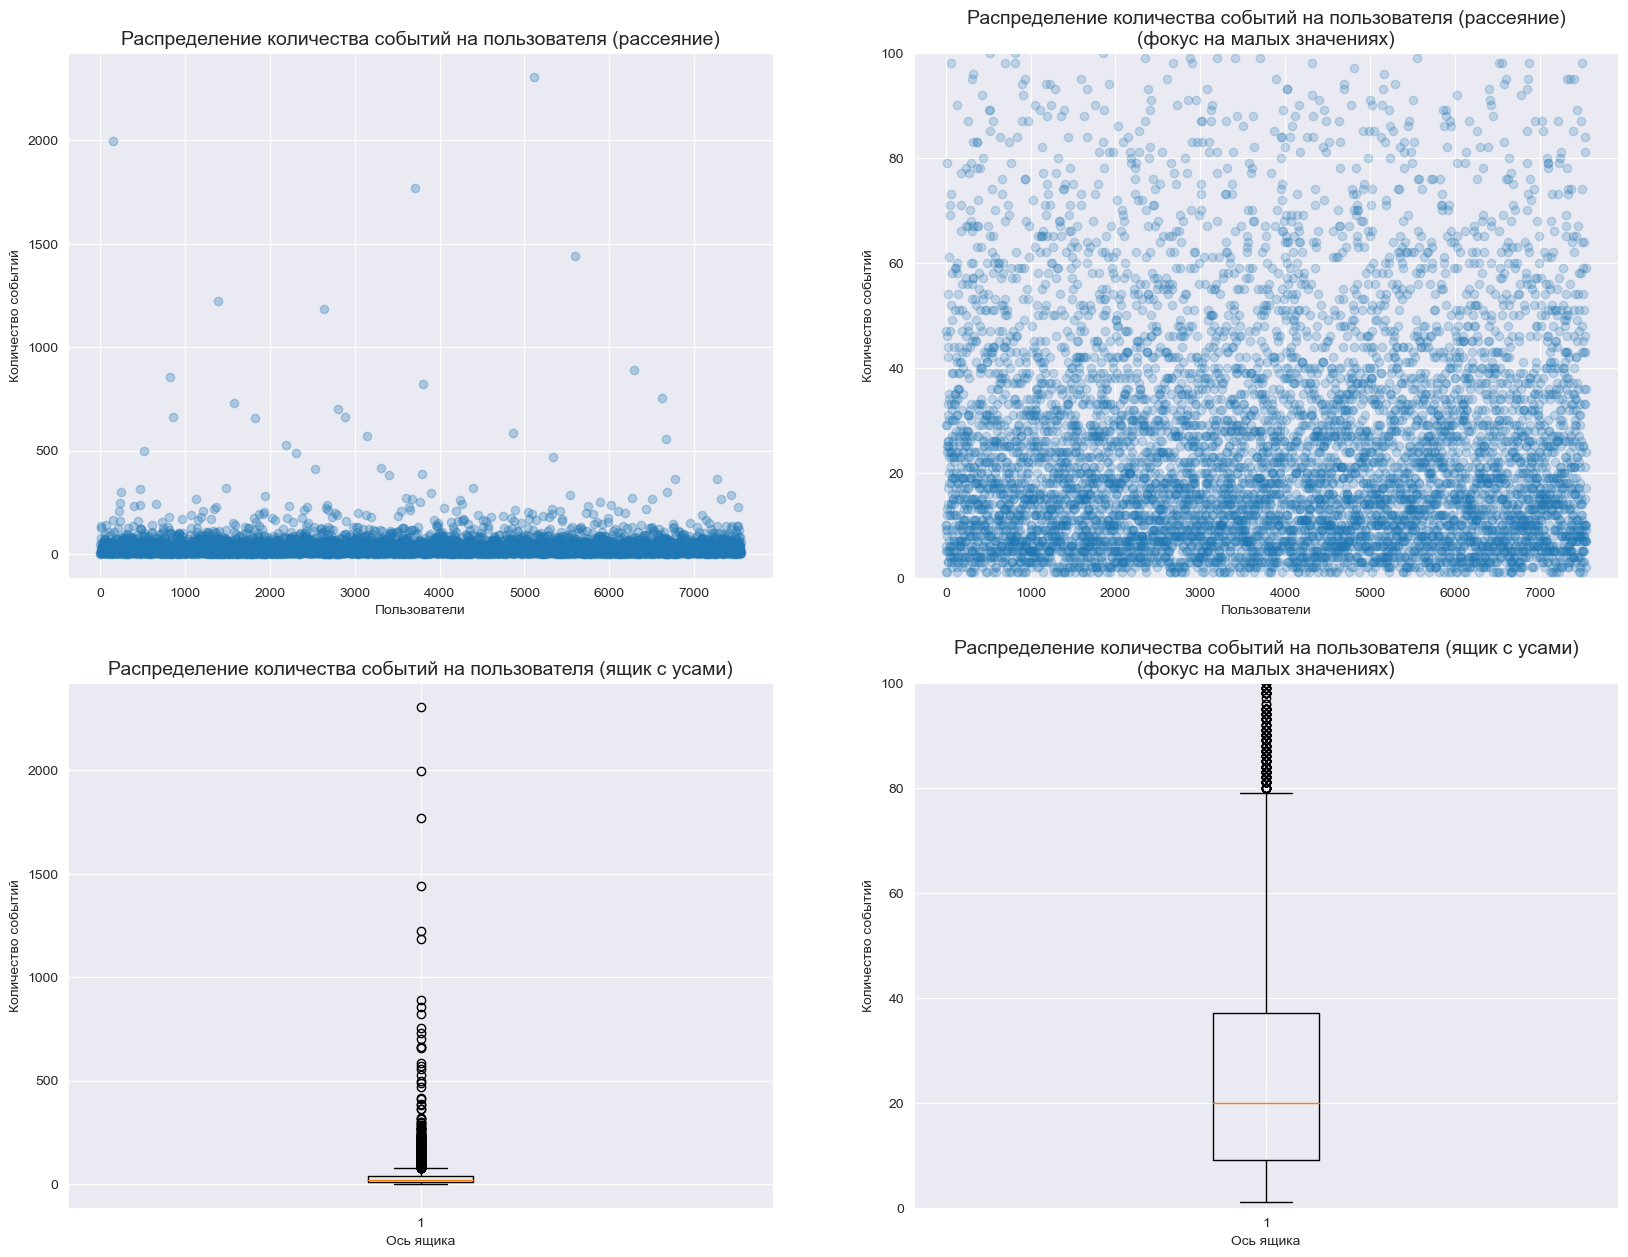

In [17]:
# визуализируем распределение событий на пользователя

# задаим стиль
sns.set_style('darkgrid')

# задаем длину оси х
x_values = pd.Series(range(0,len(user_event_pivot["event_name"])))

# задаем единую подложку для нескольких графиков
plt.figure(figsize=(20, 15))

# задаем количество строк, столбцов и номер графика, а затем строим графики
plt.subplot(2, 2, 1)
plt.scatter(x_values, user_event_pivot["event_name"], alpha=0.3)
# plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Пользователи')
plt.ylabel('Количество событий')
#plt.yticks(np.arange(0, 1310000, step=100000))
plt.title('Распределение количества событий на пользователя (рассеяние)', {'fontsize': 14})

# второй график - детализация первого с фокусом на малых значениях
plt.subplot(2, 2, 2)
plt.scatter(x_values, user_event_pivot["event_name"], alpha=0.22)
# plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Пользователи')
plt.ylabel('Количество событий')
plt.ylim(0, 100)
#plt.yticks(np.arange(0, 1310000, step=100000))
plt.title('Распределение количества событий на пользователя (рассеяние)\n(фокус на малых значениях)', {'fontsize': 14})

# чтобы понимать распределние в терминах типичности/нетипичности - добавим дмаграмму размаха
plt.subplot(2, 2, 3)
plt.boxplot(user_event_pivot["event_name"])
# plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Ось ящика')
plt.ylabel('Количество событий')
# plt.ylim(0, 100)
#plt.yticks(np.arange(0, 100000, step=10000))
plt.title('Распределение количества событий на пользователя (ящик с усами)', {'fontsize': 14})

# второй график - детализация первого с фокусом на малых значениях
plt.subplot(2, 2, 4)
plt.boxplot(user_event_pivot["event_name"])
# plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Ось ящика')
plt.ylabel('Количество событий')
plt.ylim(0, 100)
#plt.yticks(np.arange(0, 100000, step=10000))
plt.title('Распределение количества событий на пользователя (ящик с усами)\n(фокус на малых значениях)', {'fontsize': 14})

plt.show()

In [18]:
# дополним визуализацию стат.описанием параметра
user_event_pivot["event_name"].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

Как мы видим у нас крайне неоднородное распределение: основной массив событий группируется на уровне до 40 событий на пользователя, но также немало пользователей до уровня 80 событий. Пожалуй, 80 событий на пользователя - это типичное большинство, хотя 3-ий квартиль составляет 37 событий на пользователя. Хоть мы и сосредоточились на среднем значении, как мы видим, у  нас много выбросов (крайне много), поэтмоу целесообразнее сфокусироваться на медиане как на болеее робастной мере центральной тенденции. Она составляет 20 событий на пользователя, т.е. примерно 4-5 покупок, если учитывать количетсво событий в воронке (за вычетом туториала).
Разумеется, отдельно отметим выбросы. Как мы выяснили, количество событий крайне вариабельно: от 1 (отпавшие на туториале) до 2307 (постоянные и активные пользователи). Придерживаясь данным ящика с усами, мы можем утверждать, что наиболее типичные значения от 1 до 80, а остальные можем считать нетипичными, т.е. выбросами.  
Однако как меняется число событий в группах в динамике? Построим таблицу и ее визуализацию.

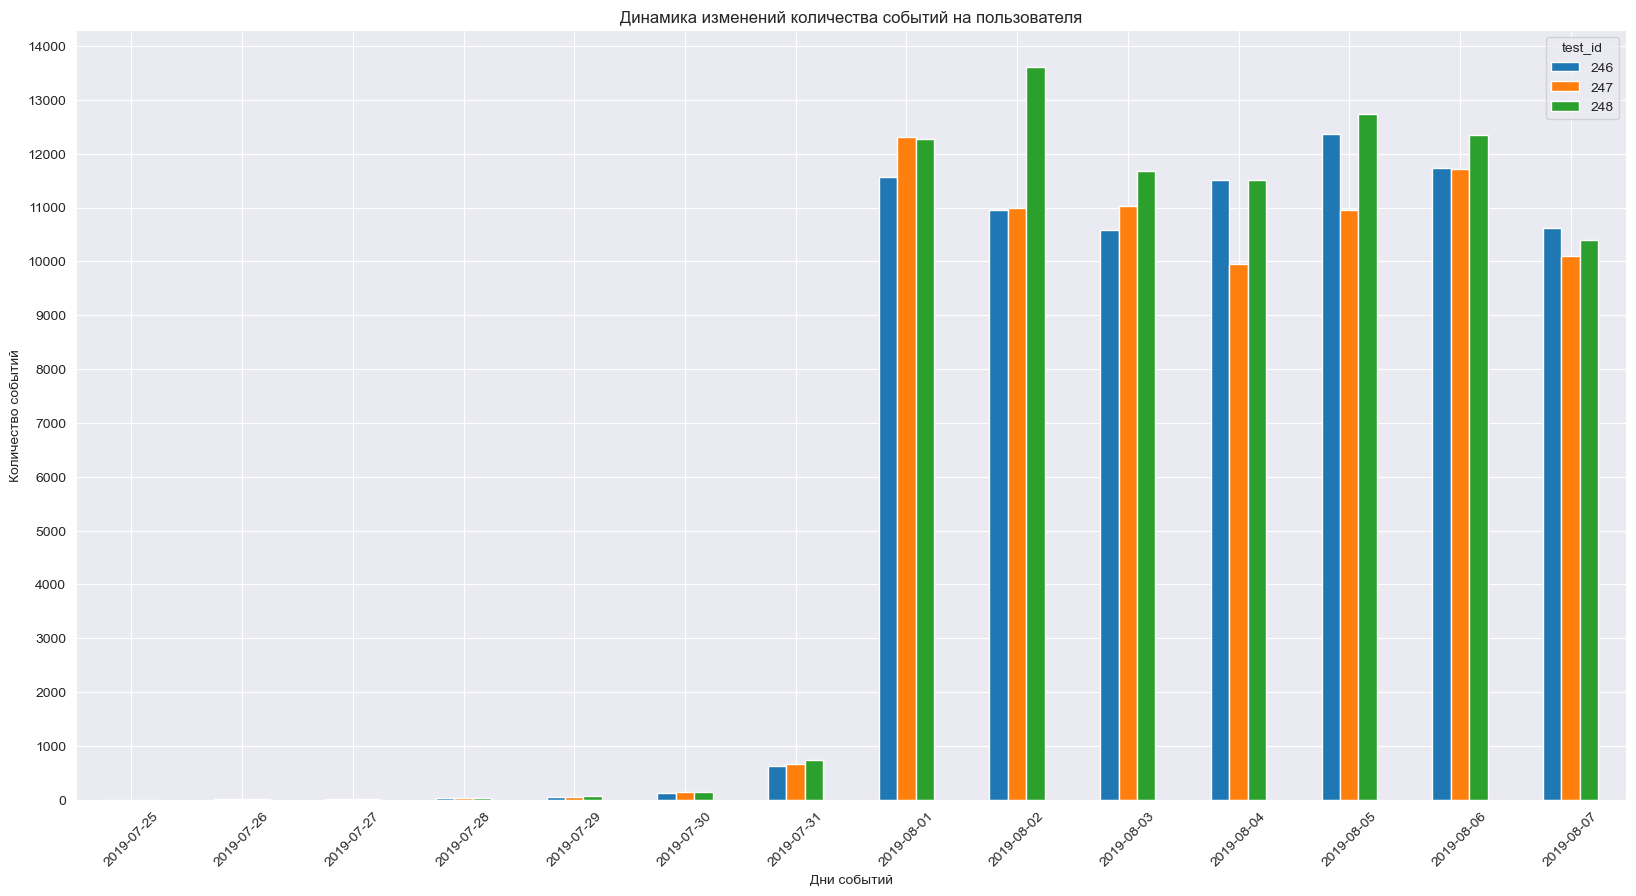

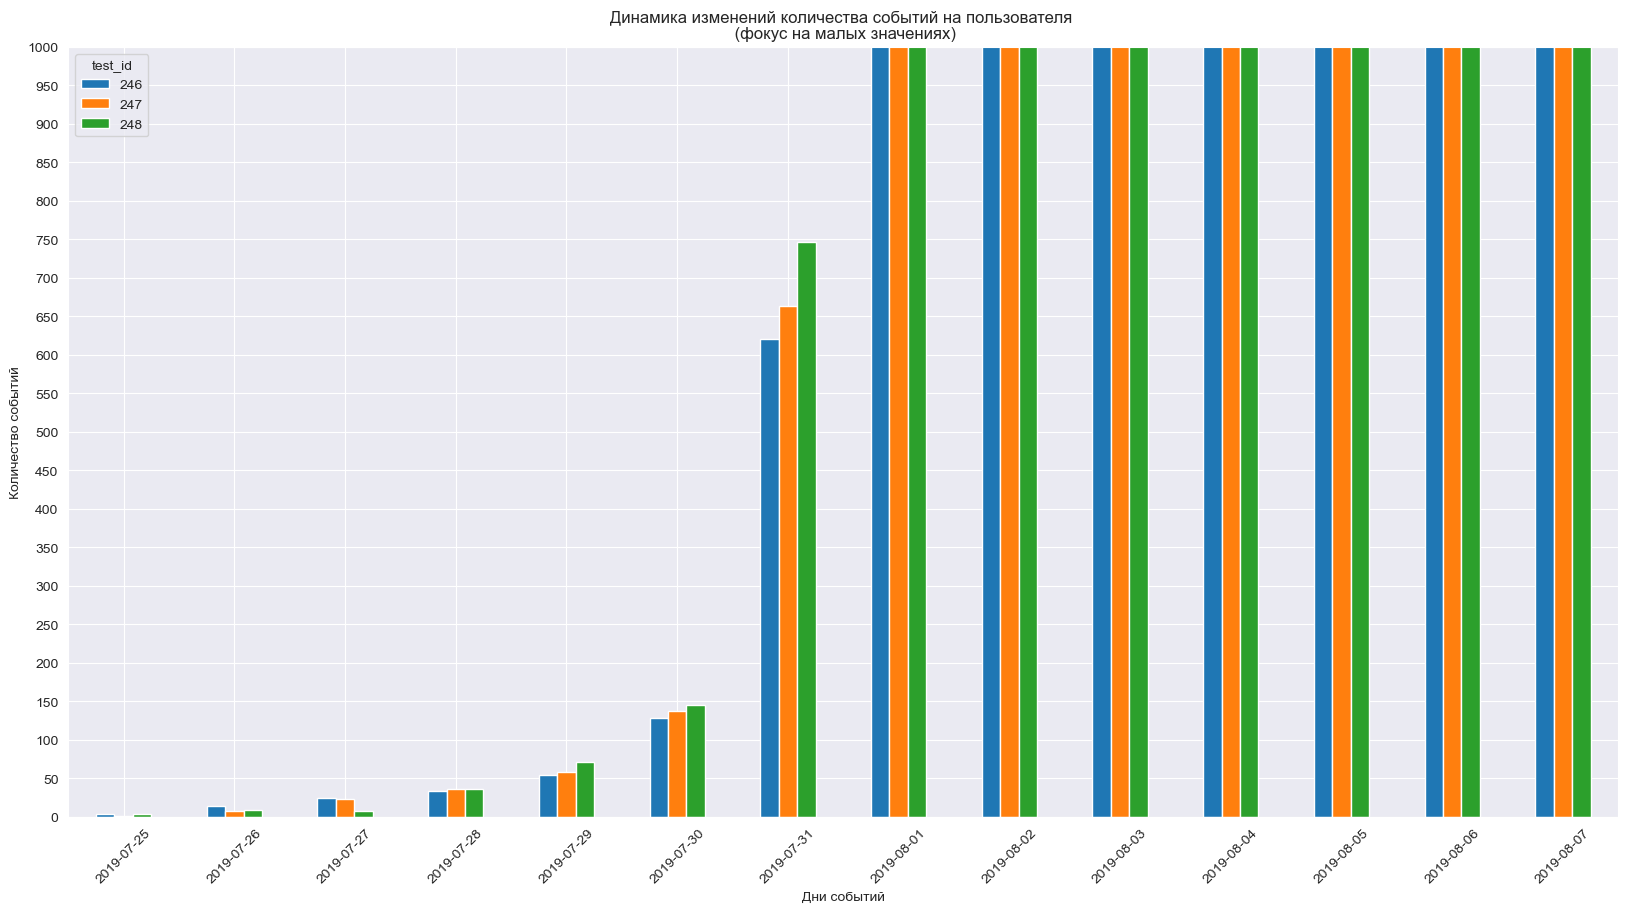

In [19]:
# создадим сводную таблицу
group_event_pivot = data.pivot_table(
    index = 'event_date',
    columns = 'test_id',
    values = 'event_name',
    aggfunc = {'event_name': 'count'}
)

# отобразим, как менялось количество событий в группах в зависимости от времени
group_event_pivot.plot(
    kind = 'bar',
    figsize = (20, 10),
    title = 'Динамика изменений количества событий на пользователя',
    xlabel = 'Дни событий',
    ylabel = 'Количество событий',
    yticks = range(0, 14001, 1000),
    rot = 45
)

# добавим фокус на малых значениях
group_event_pivot.plot(
    kind = 'bar',
    figsize = (20, 10),
    title = 'Динамика изменений количества событий на пользователя \n (фокус на малых значениях)',
    xlabel = 'Дни событий',
    ylabel = 'Количество событий',
    ylim = (0, 1000),
    yticks = range(0, 1001, 50),
    rot = 45
)

plt.show()

Как мы видим, последняя неделя июня предоставляет нам не так много данных, как первая неделя августа. Если до 1 августа у каждой из групп значения не превышают и 150 (за исключение 31 июля, где макимальный показатель - 750), то с 1 августа значения стабильно превышают отметку в 10 000. Тогда мы не можем утверждать, что у нас данные за выявленный ранее период (25.07-07.08) полные. Однако где проходит граница и как понять, что с определенного дня данные полные? Построим таблицу с событиями, сфокусировавшись на  событии `Tutorial`. Это событие маркирует пользователя на начальном этапе воронки, т.е. если мы хотим получить полные данные (а проход по воронке и есть условный лайфтайм для нас), то логичнее взять начало периода там, где инициирующее событие (предположительно - `Tutorial`) выявленно наиболее ярко. Так мы захватим наибольшее число пользователей в самом начале их прохода по конверсии (в самом начале лайфтайма).

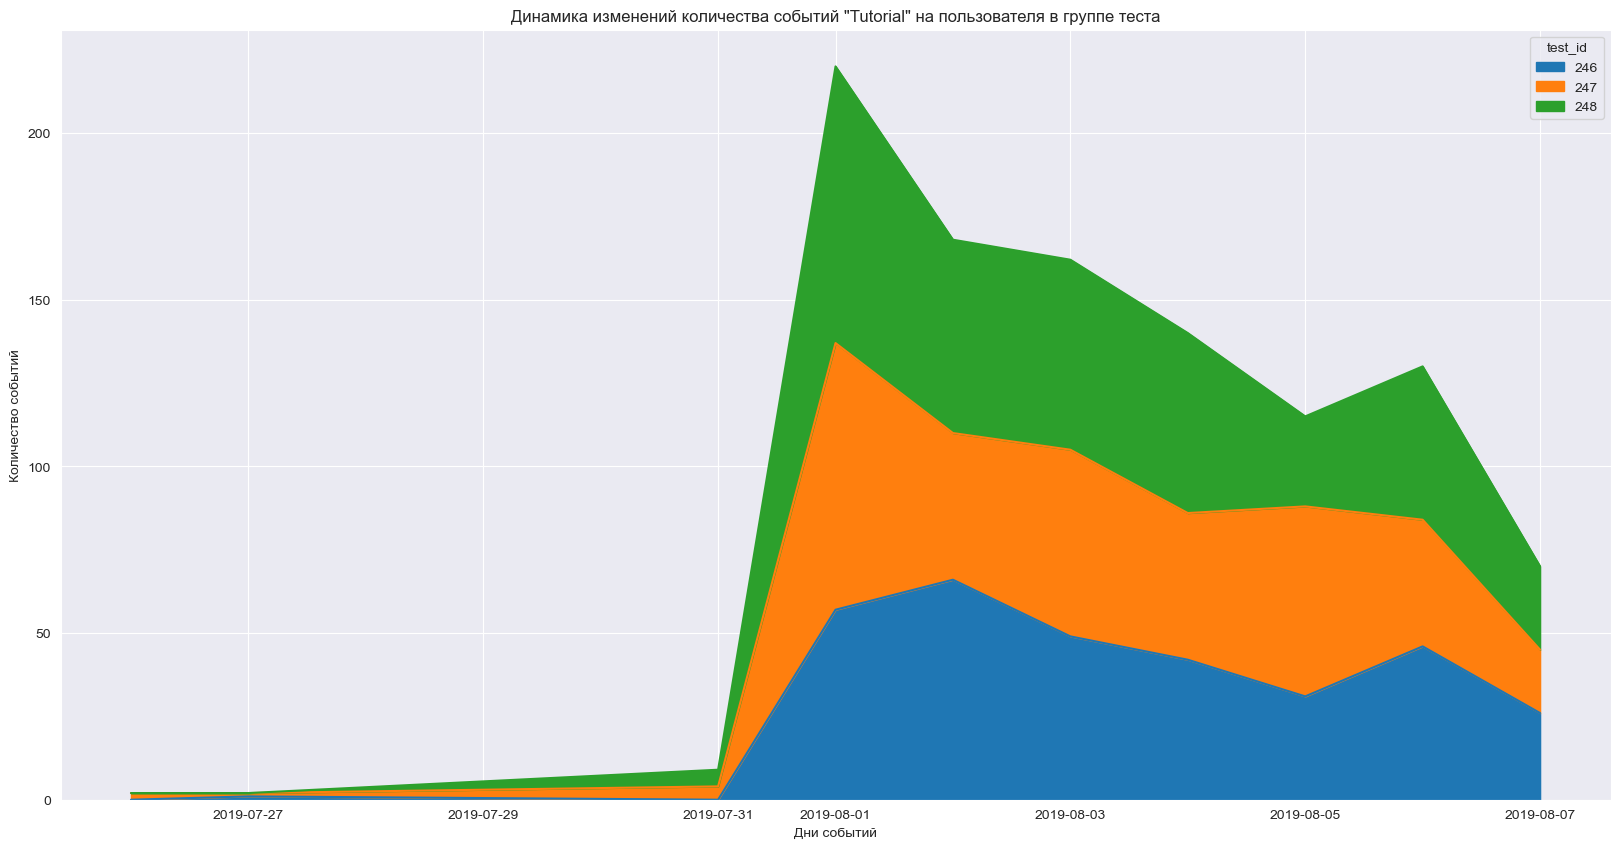

In [20]:
# создадим сводную таблицу пользователей по событию "Tutorial"
user_dynamics_pivot = data[data['event_name'] == 'Tutorial'].pivot_table(
    index = 'event_date',
    columns = 'test_id',
    values = 'event_name',
    aggfunc = {'event_name': 'count'}
)

# визуализируем ее
user_dynamics_pivot.plot(
    kind='area',
    figsize = (20, 10),
    title = 'Динамика изменений количества событий "Tutorial" на пользователя в группе теста',
    xlabel = 'Дни событий',
    ylabel = 'Количество событий'
)
plt.show()

Вполне ожидаемые значения, соответствующие предыдущим графикам. Наибольшее количество инициирующих событий `Tutorial` приходятся на 1 августа, поэтому именно здесь начинаются полные данные, т.е. такие, где мы можем отследить весь путь по конверсии (по лайфтайму). Таким образом, у нас в распоряжении данные за 1 неделю, а не 2. Отфильтруем данные и проверим, сколько у нас событий и пользователей теперь.

In [21]:
# отфильтруем датафрейм по выявленному сроку
data_filtered = data[data['event_date']>=dt.date(2019, 8, 1)]
data_filtered.head()

,event_name,user_id,event_ts,test_id,event_time,event_date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,00:08:59,2019-08-01


Мы отфильтровали датафрейм. Теперь проверим, сколько пользователей и событий у нас осталось, в особенности относительно групп теста.

In [22]:
display(f'Количество уникальных пользователей после фильтрации уменьшилось на \
{(1-data_filtered["user_id"].nunique()/data["user_id"].nunique())*100:.2f}% (из {data["user_id"].nunique()} пользователей \
осталось {data_filtered["user_id"].nunique()})')

f'Количество событий после фильтрации уменьшилось на \
{(1-data_filtered["event_name"].count()/data["event_name"].count())*100:.2f}% (из {data["event_name"].count()} событий \
осталось {data_filtered["event_name"].count()})'

'Количество уникальных пользователей после фильтрации уменьшилось на 0.23% (из 7551 пользователей осталось 7534)'

'Количество событий после фильтрации уменьшилось на 1.16% (из 243713 событий осталось 240887)'

Везде мы потеряли 0,23% уникальных пользователей и 1,16% событий от исходных данных, а значит целостность данных сохранена, однако важно учитывать сохаранена ли репрезентативность групп теста. Проверим это. 

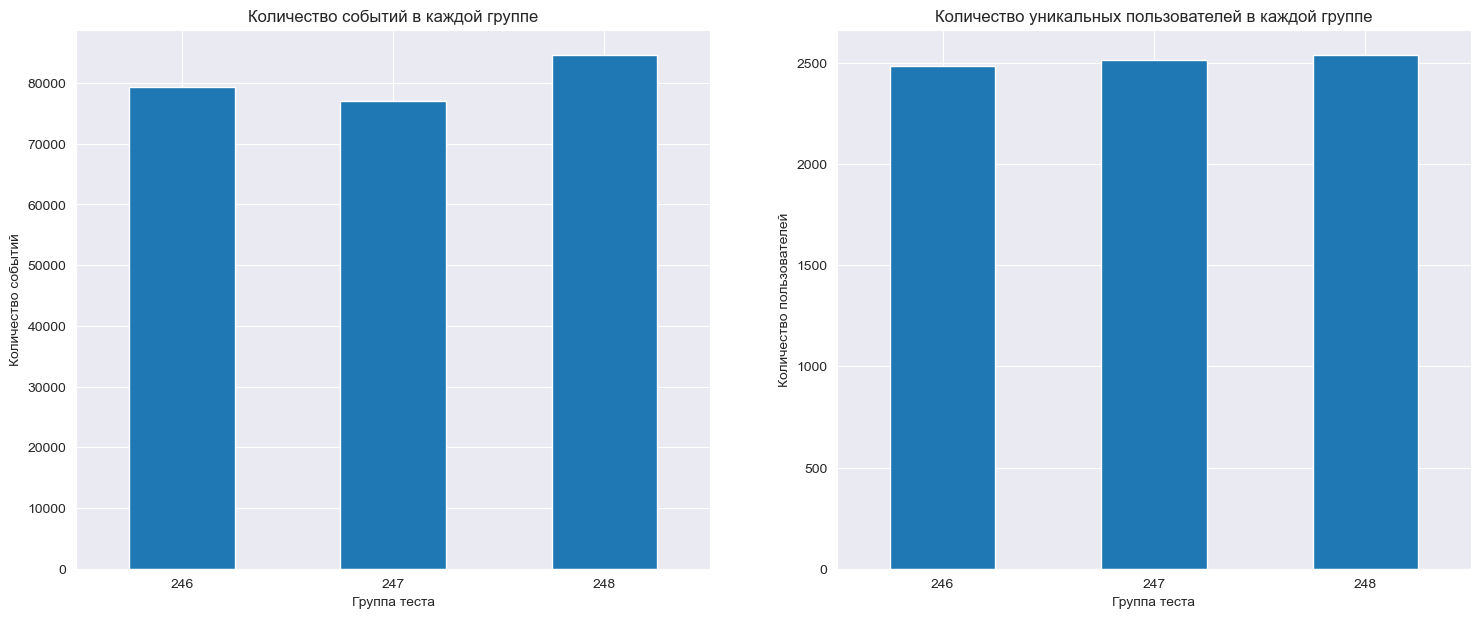

In [23]:
# сгруппируем очищенные данные по идентификатору группы и выведем события и идентификаторы пользователей
groups_grouped = data_filtered.groupby('test_id')[['event_name', 'user_id']].agg({
    'event_name': 'count', 
    'user_id': 'nunique'}
)

# визуализаруем количество событий в каждой группе
plt.subplot(1, 2, 1)
groups_grouped['event_name'].plot(
    kind='bar',
    figsize = (18, 7),
    title = 'Количество событий в каждой группе',
    xlabel = 'Группа теста',
    ylabel = 'Количество событий',
    rot = 0
)
# визуализаруем количество уникальных пользователей в каждой группе
plt.subplot(1, 2, 2)
groups_grouped['user_id'].plot(
    kind='bar',
    figsize = (18, 7),
    title = 'Количество уникальных пользователей в каждой группе',
    xlabel = 'Группа теста',
    ylabel = 'Количество пользователей',
    rot = 0
)

plt.show()

Как мы видим у нас получилось сохранить количество уникальных пользователей и количество событий равномерно распределенными по группам теста: в каждой группе события насчитывают около 8000, а уникальных пользователей - около 2500.

### Промежуточный вывод
В ходе данного этапа было выявлено, что:  
- данные де факто представлены за 2 недели (с 27.07.2019 по 07.08.2019),
- уникальных пользователей - 7551,
- событий - 243713, а уникальных событий - 5,
- среднее число событий на пользователя - 32, а медиана - 20,
- нормальное количество событий на пользователя - до 80.

В ходе анализа распределения событий по дням было выявлено, что инициирующее событие `Tutorial` как старт конвертации по воронке больше всего представлено 1 августа (в середине срока представленных данных). По данному порогу включительно была произведена очистка данных, в результате чего отфильтрованные данные имеют:
- уникальных пользователей - 7534,
- количество событий - 240887,
- количество уникальных пользователей распределено равномерно между группами теста на уровне 2500,
- количество событий распределено равномерно между группами теста на уровне 8000.

## Анализ воронки событий
На данном этапе мы проанализируем воронку событий с учетом частоты событий в каждой группе, числа пользователей для каждого события, доли конверсии на каждом новом уровне воронки с фокусом на наиболее проблемных местах, вызывающих ооток пользователей.  
Попробуем восстановить воронку. С точки зрения бизнес-логики и типовой реализации CJM логичнее всего будет выглядеть такой порядок событий в воронке:  
- просмотр туториала (`Tutorial`),
- просмотр главного экрана (`MainScreenAppear`),
- просмотр экрана предложений/товаров (`OffersScreenAppear`),
- просмотр экрана корзины (`CartScreenAppear`),
- просмотр экрана успешной покупки (`PaymentScreenSuccessful`).

Если последние события не вызывают сомнений в своем порядке, то туториал и главный экран могут быть расположены как на первом, так и на втором месте. Проверим правильность наших предположений путем подсчета количества прецедентов каждого события и отсортируем их в порядке убывания. 

In [24]:
# посчитаем количество уникальных пользователей на каждом этапе воронки и отсортируем их по убыванию
events_pivot = data_filtered.pivot_table(
    index = 'event_name',
    values = 'user_id',
    aggfunc = {'user_id': 'nunique'}
).sort_values(by='user_id', ascending=False)
events_pivot['percentage_from_all'] = (events_pivot['user_id']/data_filtered['user_id'].nunique()*100).round(2)

# создадим дополнительный датафрейм с общими значениями уникальных пользователей и процентом
total = pd.DataFrame(
    data = {'user_id': [data_filtered['user_id'].nunique()], 'percentage_from_all': [100]},
    index = ['Total']
)

# объединим датафреймы в один и отсортируем его
events_pivot = pd.concat([events_pivot, total])
events_pivot.sort_values(by='user_id', ascending=False, inplace=True)

# проверим результат
events_pivot

,user_id,percentage_from_all
Total,7534,100.00
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


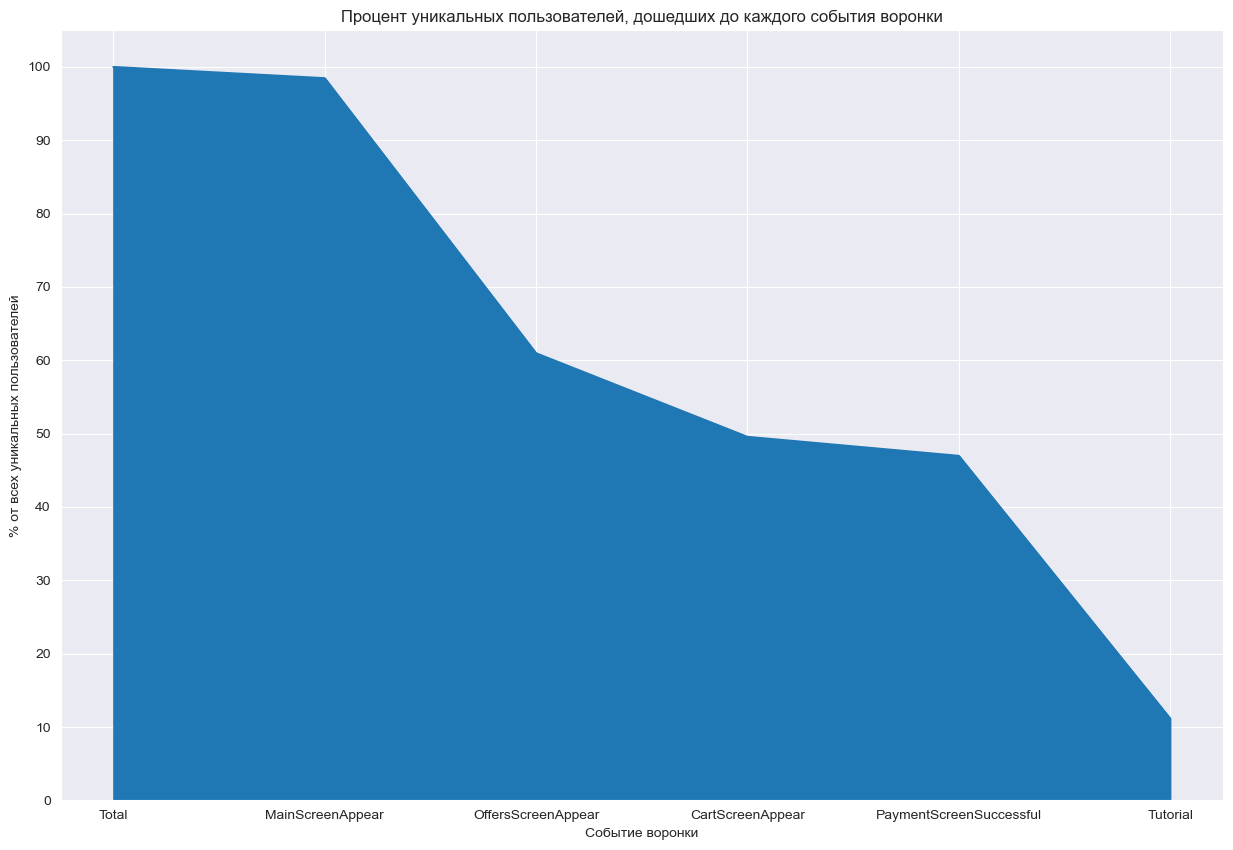

In [25]:
# визуализируем порядок событий с количеством пользователей, которые хоть раз выполнили целевое действие
events_pivot['percentage_from_all'].plot(
    kind = 'area',
    figsize = (15, 10),
    title = 'Процент уникальных пользователей, дошедших до каждого события воронки',
    xlabel = 'Событие воронки',
    ylabel = '% от всех уникальных пользователей',
    rot = 0,
    xticks = range(0, 6, 1),
    yticks = range(0, 101, 10)
)
plt.show()

К сожалнию, наша гипотеза не подтвердилась, и событие `Tutorial` имеет слишком низкий показатель, чтобы быть инициирующим для воронки. Тогда это событие опционально и запускается по инициативе пользователя.  
Дополнительно отметим, что ранее мы фильтровали исходный датафрейм именно по событию `Tutorial`, поскольку предполагали, что именно оно является началом воронки, однако, как мы можем наблюдать, это не так. Проверим, была ли ошибка в выявлении порога для фильтрации, построив аналогичный график, но с учетом события `MainScreenAppear` в качестве инициирующего.

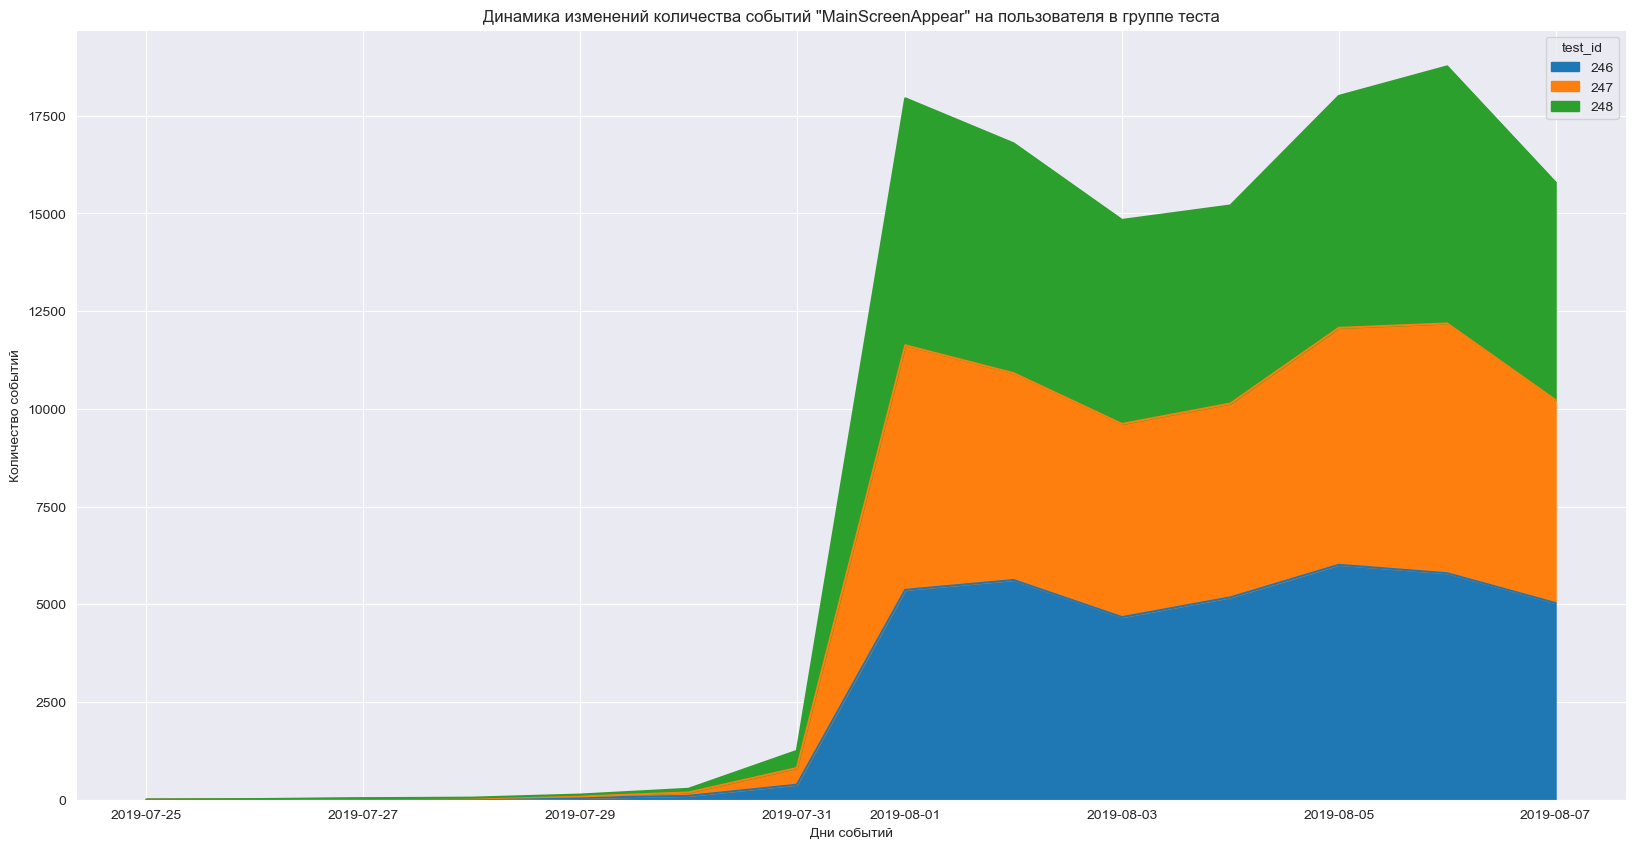

In [26]:
# создадим сводную таблицу пользователей по событию "MainScreenAppear"
user_dynamics_pivot = data[data['event_name'] == 'MainScreenAppear'].pivot_table(
    index = 'event_date',
    columns = 'test_id',
    values = 'event_name',
    aggfunc = {'event_name': 'count'}
)

# визуализируем ее
user_dynamics_pivot.plot(
    kind='area',
    figsize = (20, 10),
    title = 'Динамика изменений количества событий "MainScreenAppear" на пользователя в группе теста',
    xlabel = 'Дни событий',
    ylabel = 'Количество событий'
)
plt.show()

Хоть показатели изменились, резкий скачок в количестве событий `MainScreenAppear` остается на том же дне, что и в случае с туториалом, поэтому фильтрация, хоть и с ошибочным предположением, была проведена верно.  
Так, мы можем выявить последовательные события воронки:  
- просмотр главного экрана (`MainScreenAppear`),
- просмотр экрана предложений/товаров (`OffersScreenAppear`),
- просмотр экрана корзины (`CartScreenAppear`),
- просмотр экрана успешной покупки (`PaymentScreenSuccessful`).  

Событие `Tutorial` скорее всего опционально и запускается при желании пользователя, а не по первому запуску приложения.

Теперь посмотрим, каков отток пользовтелей на каждом этапе воронки.

In [27]:
# создадим сводную таблицу, где посчитаем количество уникальных пользователей, 
# дощедших до каждого этапа, и отсортируем по убыванию
data_funnel = data_filtered[data_filtered['event_name'] != 'Tutorial'].pivot_table(
    index = 'event_name',
    values = 'user_id',
    #columns = 'user_id',
    aggfunc = {'user_id': 'nunique'}
).sort_values(by='user_id', ascending=False)

In [28]:
# создадим дополнительный датафрейм с общими значениями уникальных пользователей и процентом
total = pd.DataFrame(
    data = {'user_id': [data_filtered['user_id'].nunique()]},
    index = ['Total']
)

data_funnel = pd.concat([data_funnel, total])
data_funnel.sort_values(by='user_id', ascending=False, inplace=True)

# дополним таблицу новым столбцом с процентным убыванием от каждого этапа и округлим до 2 знаков после запятой
data_funnel['percentage_loss'] = ((data_funnel.pct_change().fillna(0))*100).round(2)
data_funnel.T

,Total,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
user_id,7534.0,7419.00,4593.00,3734.0,3539.00
percentage_loss,0.0,-1.53,-38.09,-18.7,-5.22


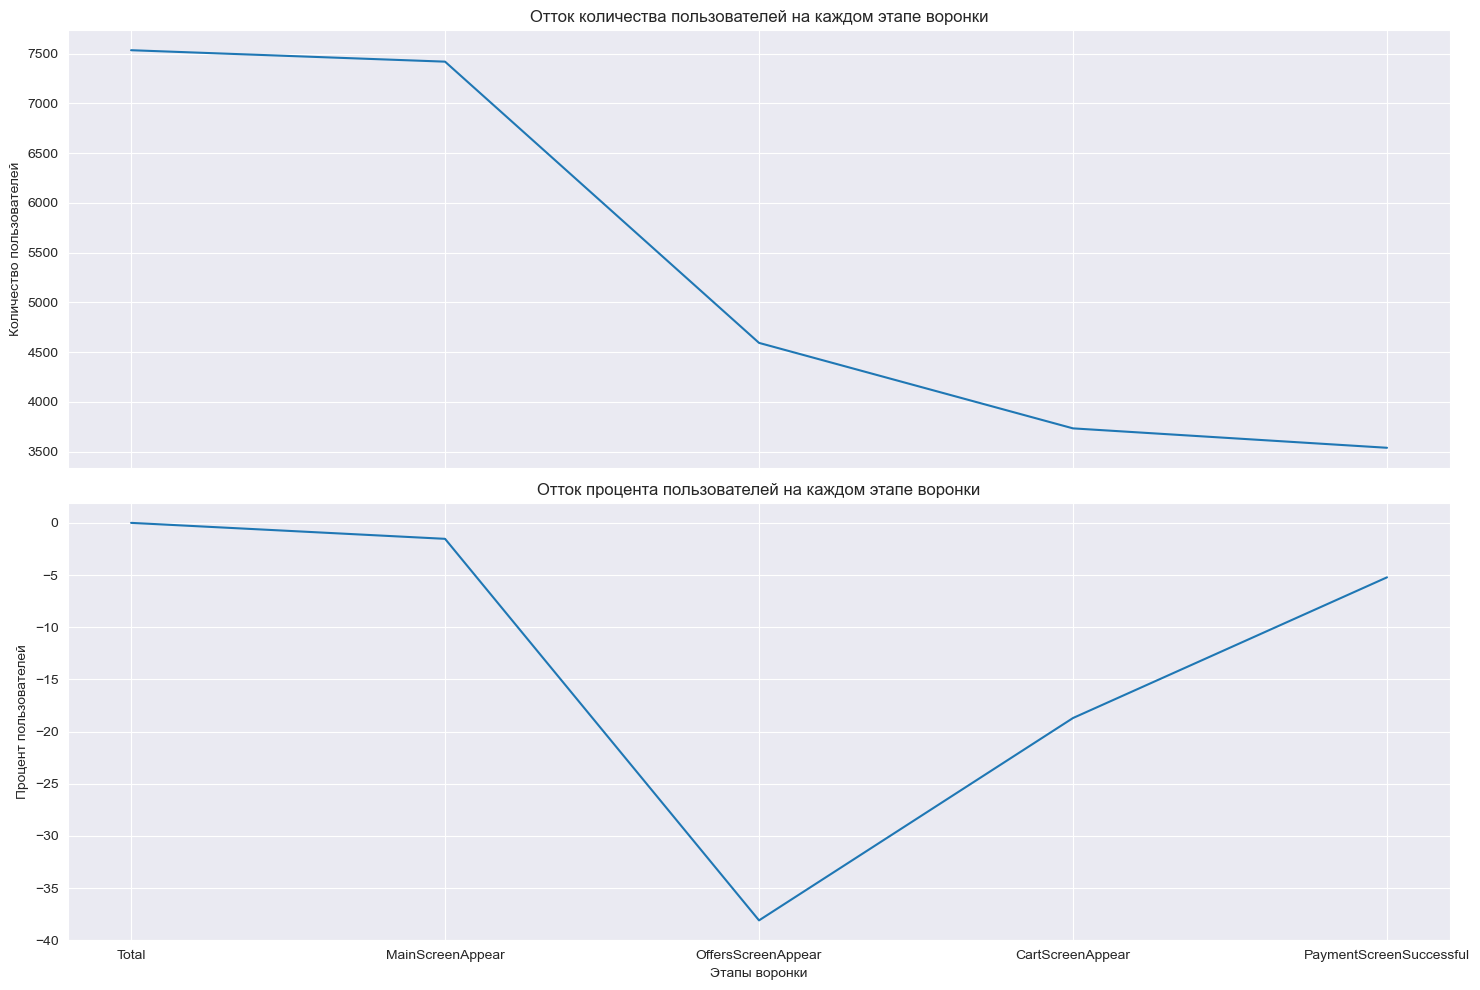

In [29]:
# визуализируем полученные данные по воронке
# создаем график конверсии по воронке по количесвту уникальных пользователей
fig = plt.figure()
ax1 = plt.subplot(2, 1, 1)
data_funnel['user_id'].plot(
    kind = 'line',
    figsize = (15, 10),
    title = 'Отток количества пользователей на каждом этапе воронки',
    xlabel = 'Этапы воронки',
    ylabel = 'Количество пользователей',
    xticks = range(0, 5, 1)
)

# создаем график конверсии по воронке по проценту оттока пользователей
ax2 = plt.subplot(2, 1, 2, sharex = ax1)
data_funnel['percentage_loss'].plot(
    kind = 'line',
    figsize = (15, 10),
    title = 'Отток процента пользователей на каждом этапе воронки',
    xlabel = 'Этапы воронки',
    ylabel = 'Процент пользователей',
    xticks = range(0, 5, 1),
    yticks = range(-40, 1, 5)
)
plt.tight_layout()
plt.show()

Как мы видим, 1,5% устанавливают приложение, но не начинают им пользоваться. Наибольший отток (38%) наблюдается при переходе пользователей на этап выбора товаров. Это знак, что пользователи испытывают трудности с выбором товаров и не переходят на карточки товаров, а, следовательно, не дойдут до корзины и последующей покупки. На этапе корзины мы имеем 18,7% оттока, т.е. почти каждый 5-ый не доходит до корзины, а до покупки с запоненной корзиной - 5%. Если отток на этапе покупки с полной корзиной относительно не высок и может объясняться нерешительностью пользователей, то показатели оттока на этапе просмотра товаров и корзины достаточно высоки и требуют внимания команды. Такие показатели оттока на этапе просмотра товаров свидетельствуют о проблемах с CJM, на что следует обратить внимание команде frontend-разработки и маркетологам, а высокий отток на этапе корзины может означать, что пользователи не находят то, зачем пришли, или не довольны ценой, поэтому здесь будет полезно посмотреть на располагаемый ассортимент и принципы ценообразования.

Теперь выясним, какова итоговая конверсия в покупку.

In [30]:
f'Конверсия в покупку составляет \
{(data_filtered[data_filtered["event_name"]=="PaymentScreenSuccessful"]["user_id"].nunique()/data_filtered[data_filtered["event_name"]=="MainScreenAppear"]["user_id"].nunique())*100:.1f}%'

'Конверсия в покупку составляет 47.7%'

Конверсия в 47,7% хороший результат, т.к. около половины пользователей доходят весь путь по воронке с конечной покупкой. Стартап показывает неплохие результаты, а при решении проблем с CJM и дополнительной стимуляцией покупателей можно ожидать показатель до 55%.

### Промежуточный вывод
На данном этапе мы восстановили последовательные этапы воронки, которые включают:
- просмотр главного экрана (`MainScreenAppear`),
- просмотр экрана предложений/товаров (`OffersScreenAppear`),
- просмотр экрана корзины (`CartScreenAppear`),
- просмотр экрана успешной покупки (`PaymentScreenSuccessful`).  

Этап туториала не является обязательным, поэтому в воронке он не учитывается.
Наибольший отток потенциальных покупателей наблюдается на этапе просмотра карточек товаров (38%), т.е. каждый третий перестает интересоваться предлагаемыми товарами. Однако у стартапа остается достаточно высокой конверсия в покупку - 47,7%, что потенциально можно увеличить. Высокий процент оттока при переходе на карточки товара указывают на трудности с пользовательским опытом в приложении, а относительно высокий отток на этапе корзины сигнализирует о неудачном поиске или неудовлетворенностью предложениями приложения. При выявлении и адаптации проблемных мест приложения можно ожидать повышения конверсии в покупку до 55%.  

---------------------------------------------------

## Анализ результатов А/А/В-теста и статистическая проверка гипотез
На данномм этапе нам предстоит изучить результаты эксперимента, связанного с использованием нового шрифта в приложении. Поскольку вопрос о внедрении нового шрифта стоит остро, для теста было выделено 3 группы: 2 контрольные - 246 и 247 и 1 тестовая - 248. На данных представленных групп выясним есть ли различия по доле конверсии пользователей групп на следующий этап воронки. Для проверки проведем сначала А/А-тест, а затем приступим к А/В-тесту.  
Для начала вспомним, сколько всего пользователей в каждой группе.

In [31]:
# создадим список с группами теста
test_groups = [246, 247, 248]

# через цикл посчитаем количество пользователей в каждой группе
for group in test_groups:
    print(f'Пользователей в группе {group}: {data_filtered[data_filtered["test_id"]==group]["user_id"].nunique()}')

Пользователей в группе 246: 2484
Пользователей в группе 247: 2513
Пользователей в группе 248: 2537


Как мы и отмечали ранее, пользователи распределены достаточно равномерно вокруг значения 2500. Однако важно для чистоты теста проверить, не пересекаются ли пользователи в группах (т.е. нет ли пользователей, представленных в нескольких группах). Проверим это.

In [32]:
# создадим список с id пользователей, куда будем добавлять тех, кто представлен в обеих группах сразу
double_users = []

# создадим цикл, в котором список из уникальных пользователей группы А будет сличаться с аналогичным списком группы В
for id_num in data_filtered[data_filtered['test_id'] == 246]['user_id'].unique():
    if id_num in data_filtered[data_filtered['test_id'] == 247]['user_id'].unique():
        if id_num in data_filtered[data_filtered['test_id'] == 248]['user_id'].unique():
            # все id, найденные в обеих группах, добавляются в отдельный список
            double_users.append(id_num)
        
f'Выявлено {len(double_users)} идентификаторов, присутствующих в нескольких группах, и эти идентификаторы - {double_users}'

'Выявлено 0 идентификаторов, присутствующих в нескольких группах, и эти идентификаторы - []'

Как мы видим, пересекающихся пользователей нет. Тогда мы можем приступить к проверочному А/А-тесту. Поскольку нас интересуют пропорции пользователей, перешедших на следующий этап вовронки, то мы изберем Z-критерий для тестирования гипотез.  
Z-критерий высчитывается по следующей формуле:

$\LARGE Z \approx \frac{(P_1-P_2)-(\pi_1-\pi_2)}{\sqrt{P(1-P)(1/n_1+1/n_2)}}$

Гипотезы будем проверять на конверсии в следующий этап воронки, поэтому создадим основу для выборок.

In [33]:
# подготовим данные для проверки гипотез
samples = data_filtered.pivot_table(
    index = 'event_name',
    columns = 'test_id',
    values = 'user_id',
    aggfunc = {'user_id': 'nunique'}
).sort_values(by=246, ascending=False)#.reset_index(drop=False)

# создадим дополнительный датафрейм с общими значениями уникальных пользователей и процентом
total = pd.DataFrame(
    data = {
        246: [data_filtered[data_filtered['test_id']==246]['user_id'].nunique()],
        247: [data_filtered[data_filtered['test_id']==247]['user_id'].nunique()],
        248: [data_filtered[data_filtered['test_id']==248]['user_id'].nunique()]
    },
    index = ['Total']
)

# объединим датафрейм с общим количеством уникальных пользователей 
samples = pd.concat([samples, total])
samples.sort_values(by=246, ascending=False, inplace=True)


# проверим результат
samples

,246,247,248
Total,2484,2513,2537
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Теперь, когда данные готовы, подготовим кодовую базу для проверки гипотез. Создадим функцию, которая будет проверять статистические различия пропорций по Z-критерию.

In [34]:
# объявим фукнцию
def get_z(df, cv_step='', groups=[], alpha=0.5):
    
    #высчитываем пропорцию в группах
    p1 = df.loc[cv_step, groups[0]]/df.loc['Total', groups[0]]
    p2 = df.loc[cv_step, groups[1]]/df.loc['Total', groups[1]]
    
    #высчитываем комбинированную пропорцию
    p_combi = (df.loc[cv_step, groups[0]] + df.loc[cv_step, groups[1]]) / (df.loc['Total', groups[0]] + df.loc['Total', groups[1]])
    
    #высчитываем разницу пропорций
    p_diff = p1-p2
    
    # считаем z-статистику в стандартных отклонениях
    z_value = p_diff / mth.sqrt(p_combi * (1 - p_combi) * (1/df.loc['Total', groups[0]] + 1/df.loc['Total', groups[1]]))
    
    # задаем нормальное распределение
    distribution = st.norm(0, 1)
    
    # считаем p-value
    p_value = (1 - distribution.cdf(abs(z_value))) * 2
    
    # выводим результат
    print('P-value составляет ', (p_value).round(4))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу в пользу альтернативной, т.к. между долями есть статистически значимая разница')
    else:
        print('Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима')

Теперь функция готова, и можно считать статистическую разницу. Однако последний важный момент: поскольку мы будем проводить тесты несколько раз, а именно: группу $А_1$(246) с группой $А_2$(247), а затем группу $В$(248) с каждой из предыдущих групп, то в итоге у нас получается 3 теста(6 гипотез), а это значит, что мы увеличиваем вероятность ошибки первого рода (а именно групповую вероятность ошибки первого рода - *FWER*). Доли (сравниваемые значения) будут разные, поэтому они количество тестов не увеличивают. Для этого мы введем поправку Бонферрони, которая высчитывается по следующей формуле:

$\LARGE \alpha_{corr} = \alpha/m $

Таким образом, текущий уровень значимости мы ставим на значении в 6 раз меньше предполагаемого, а именно:  

$\LARGE \alpha_{corr} = \alpha/m = 0,05/10 = 0,005$

Проведем тестовую контрольную проверку групп, т.е. А/А-тест. Проверим конверсию пользователей:  
- в просмотр главного экрана,
- в просмотры товара,
- в просмотры корзины,
- в покупку,
- в прохождение туториала.

Соответственно гипотезы для тестов следующие:  

1) Проверка конверсии в просмотр главного экрана:
- $H_0 = $ **доли конверсии в просмотр главного экрана у групп 246 и 247 равны**
- $H_1 = $ **доли конверсии в просмотр главного экрана у групп 246 и 247 не равны**

2) Проверка конверсии в просмотры товара:
- $H_0 = $ **доли конверсии в просмотры товара у групп 246 и 247 равны**
- $H_1 = $ **доли конверсии в просмотры товара у групп 246 и 247 не равны**

3) Проверка конверсии в просмотры корзины:
- $H_0 = $ **доли конверсии в просмотры корзины у групп 246 и 247 равны**
- $H_1 = $ **доли конверсии в просмотры корзины у групп 246 и 247 не равны**

4) Проверка конверсии в покупку:
- $H_0 = $ **доли конверсии в покупку у групп 246 и 247 равны**
- $H_1 = $ **доли конверсии в покупку у групп 246 и 247 не равны**

5) Проверка конверсии в прохождение туториала:
- $H_0 = $ **доли конверсии в прохождение туториала у групп 246 и 247 равны**
- $H_1 = $ **доли конверсии в прохождение туториала у групп 246 и 247 не равны**

In [35]:
# зададим списками группы и события
test_groups = [246, 247]
events_cv = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# циклом проведем все проверки 
for cv in events_cv:
    print(f'Результаты проверки доли конверсии групп {test_groups[0]} и {test_groups[1]} в событие {cv}:')
    get_z(samples, cv_step=cv, groups=test_groups, alpha=0.005)
    print('\n')

Результаты проверки доли конверсии групп 246 и 247 в событие MainScreenAppear:
P-value составляет  0.7571
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп 246 и 247 в событие OffersScreenAppear:
P-value составляет  0.2481
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп 246 и 247 в событие CartScreenAppear:
P-value составляет  0.2288
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп 246 и 247 в событие PaymentScreenSuccessful:
P-value составляет  0.1146
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп 246 и 247 в событие Tutorial:
P-value составляет  0.9377
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима




Как мы видим, конверсия у изначально идентичных групп 246 и 247 во все события воронки статистически не разлчины (p-value у каждой проверки более 10%), а, значит, все подготовлено к А/В-тесту верно и мы можем приступить к проверке стат. различия долей конверсии у групп 246 и 247 относительно группы 248.
Теперь посмотрим, какие результаты будут при А/В-тесте. Для этого объединим контрольные группы в единую группа А в текущем датафрейме. Так мы получим общие данные для сравнения с группой В на основе отношения уже общих показателей группы А.


In [36]:
# добавим в датафрейм поле с показателями уникальных пользователей для обеих контрольных групп
samples['a_combi'] = samples[246] + samples[247]

# выведем результат для проверки
samples

,246,247,248,a_combi
Total,2484,2513,2537,4997
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [37]:
# проверим, равна ли сумма уникальных пользователей комбинированной 
# контрольной группы и тестируемой группы всем уникальным пользователям
if (samples.loc['Total', 'a_combi']+samples.loc['Total', 248]) == (data_filtered['user_id'].nunique()):
    print('Общее число уникальных пользователей соответствует сумме уникальных пользователей в группах А и В \nВсе в порядке')
else:
    print('Общее число уникальных пользователей не соответствует сумме уникальных пользователей в группах А и В \nДанные потеряны')

Общее число уникальных пользователей соответствует сумме уникальных пользователей в группах А и В 
Все в порядке


Поскольку показатели совпадают, можно приступать к проверке гипотез о равенстве долей групп А и В. Соответственно гипотезы для тестов следующие:  

1) Проверка конверсии в просмотр главного экрана:
- $H_0 = $ **доли конверсии в просмотр главного экрана у групп a_combi и 248 равны**
- $H_1 = $ **доли конверсии в просмотр главного экрана у групп a_combi и 248 не равны**

2) Проверка конверсии в просмотры товара:
- $H_0 = $ **доли конверсии в просмотры товара у групп a_combi и 248 равны**
- $H_1 = $ **доли конверсии в просмотры товара у групп a_combi и 248 не равны**

3) Проверка конверсии в просмотры корзины:
- $H_0 = $ **доли конверсии в просмотры корзины у групп a_combi и 248 равны**
- $H_1 = $ **доли конверсии в просмотры корзины у групп a_combi и 248 не равны**

4) Проверка конверсии в покупку:
- $H_0 = $ **доли конверсии в покупку у групп a_combi и 248 равны**
- $H_1 = $ **доли конверсии в покупку у групп a_combi и 248 не равны**

5) Проверка конверсии в прохождение туториала:
- $H_0 = $ **доли конверсии в прохождение туториала у групп a_combi и 248 равны**
- $H_1 = $ **доли конверсии в прохождение туториала у групп a_combi и 248 не равны**

In [38]:
# зададим списком группы и события
test_groups = ['a_combi', 248]
events_cv = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# циклом проведем все проверки 
for cv in events_cv:
    print(f'Результаты проверки доли конверсии групп {test_groups[0]} и {test_groups[1]} в событие {cv}:')
    get_z(samples, cv_step=cv, groups=test_groups, alpha=0.005)
    print('\n')

Результаты проверки доли конверсии групп a_combi и 248 в событие MainScreenAppear:
P-value составляет  0.2942
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп a_combi и 248 в событие OffersScreenAppear:
P-value составляет  0.4343
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп a_combi и 248 в событие CartScreenAppear:
P-value составляет  0.1818
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп a_combi и 248 в событие PaymentScreenSuccessful:
P-value составляет  0.6004
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима


Результаты проверки доли конверсии групп a_combi и 248 в событие Tutorial:
P-value составляет  0.7649
Подтверждаем нулевую гипотезу, т.к. разница долей статистически не значима




Как мы видим, результаты множественного сравнения конверсии 248 группы относительно конверсии единой контрольной группы также не фиксируют статистического различия в конверсии всех этапов воронки, т.к. p-value каждого теста при нулевой гипотезе выше 18%, что более чем достаточно для подкрепления нулевой гипотезы. А это означает, что множественная проверка гипотеза дала отрицательный результат, и группа 248 в приложении никак статистически не проявила себя в динамике конверсии относительно введения нового шрифта.

### Промежуточные выводы
На данном этапе мы провели множественную проверку гипотез о равенстве долей конверсии пользователей на всех этапах воронки (включая опциональные). Для этого мы проверили пользователей на однородность принадлежности к группам теста, а также выбрали Z-критерий в качестве статистики и применили поправку Бонферрони для стабилизации множественной вероятности ошибки первого рода (*FWER*). В итоге проверка конверсий контрольных групп не показала статистически значимых различий, что свидетельствует о чистоте и точности теста. Такой же отрицательный результат на статистическое различие продемонстрировало А/В-тестирование, на основании которого мы придерживаемся нулевой гипотезы о равенстве долей конверсии контрольных и тестируемой групп на всех этапах воронки.

-------------------------------------------------

## Выводы
В результате всех этапов исследования и подведения итогов теста мы можем сделать следующие выводы: 
- для анализа представлены данные за 2 недели, хотя полнотой отличаются данные только за вторую неделю, на основе чего и была проведена фильтрация данных для дальнейшего анализа;
- воронка приложения включает 5 событий, из которых 1 опциональное (туториал), а остальные выполняются в следующей последовательности: главный экран, карточки товаров, корзина, экран успешной покупки;
- при достаточно высокой конверсии в покупку (47,7%) наблюдается сильный спад в конверсии в просмотр товара (38%), что связано вероятнее всего со сложностью пользовательского опыта в приложении, а также относительно высокий показатель оттока на этапе корзины (18,7%), что указывает на ассортимент и принципы ценообразования; 
- при введении шрифта для тестируемой группы были отмечены 3 группы (суммарно 7551 пользователь): 2 контрольные и 1 тестируемая, которая не демонстрирует положительные статистические отличия в конверсии на всех этапах воронки, т.е. статистически значимых различий в конверсии на основе z-критерия выявить не удалось.